# Setup

# MissionBio Tapestri Single-Cell Analysis with EspressoPro

This notebook demonstrates a comprehensive single-cell protein analysis pipeline using MissionBio Tapestri data. The analysis leverages EspressoPro for automated cell type annotation and includes advanced refinement techniques.

## Key Features:
- **Data**: Multi-sample PBMC dataset (HD01 and HD02 samples)
- **Analysis**: Complete protein-based single-cell characterization
- **Methods**: UMAP dimensionality reduction, graph-based clustering, automated annotation
- **Refinement**: Small cluster handling, mixed cluster resolution, cluster-based improvements, mast and/or custom cell type detection

## Workflow Overview:
1. Data loading and setup
2. Sample-wise analysis (normalization, dimensionality reduction, clustering)
3. EspressoPro automated cell type prediction
4. Multi-step annotation refinement
5. Final visualization and validation

## Loading modules

In [1]:
import missionbio.mosaic as ms
import os
import espressopro as ep
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import random
import plotly.graph_objects as go
import copy

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import scanpy as sc
from anndata import AnnData

/Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/missionbio/mosaic/io.py:47: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import warnings
import pandas as pd

# silence globally
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

## Setting seed

conda env config vars set PYTHONHASHSEED=0

In [3]:
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)

In [4]:
def ensure_pythonhashseed(seed=0):
    current_seed = os.environ.get("PYTHONHASHSEED")

    seed = str(seed)
    if current_seed is None or current_seed != seed:
        print(f'Setting PYTHONHASHSEED="{seed}"')
        os.environ["PYTHONHASHSEED"] = seed
        # restart the current process
        os.execl(sys.executable, sys.executable, *sys.argv)

In [5]:
import random

hash = random.getrandbits(128)

print("hash value: %032x" % hash)

hash value: bdd640fb06671ad11c80317fa3b1799d


# Loading data

In [6]:
PBMC_samples = ms.load_example_dataset(path="Multisample PBMC", single=False)

          0/2: 

            0%: 

            0%: 

## Data Loading

Loading the MissionBio example multi-sample PBMC dataset. This dataset contains protein expression measurements from multiple healthy donor samples (HD01, HD02) measured using the Tapestri platform.

# PBMC - HD01 Analysis

In [7]:
PBMC_HD01 = PBMC_samples.samples[0]

In [8]:
PBMC_HD01

## Remove non variable ADTs

In [9]:
PBMC_HD01.protein = PBMC_HD01.protein.drop(['IgG1', 'IgG2a', 'IgG2b'])

## Normalisation

Performing two essential preprocessing steps:
1. **Normalization**: Corrects for technical variations and library size differences between cells using ADT CLR normalisation with Seurat flavour (akin to Muon ADT normalisation)
2. **Scaling**: Standardizes protein expression values to enable proper dimensionality reduction and downstream analysis

These steps ensure that subsequent dimensionality reduction and clustering are not biased by technical artifacts.

In [10]:
ep.Normalise_protein_data(PBMC_HD01, inplace=True, axis=1, flavor="seurat")
ep.Scale_protein_data(PBMC_HD01, inplace=True)

## Dimentionality reduction

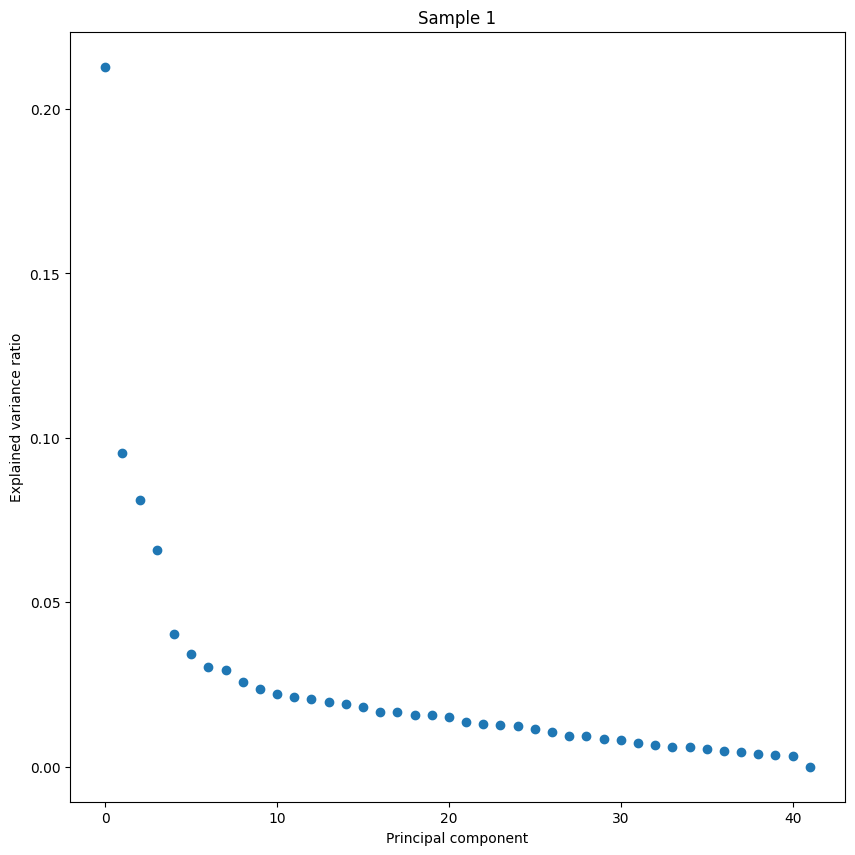

In [11]:
PBMC_HD01.protein.run_pca(attribute='Scaled_reads', components=45,show_plot=True, random_state=42, svd_solver='randomized')

We retain only those components that explain the majority of the variance, selecting the number of components at the point where additional components yield diminishing returns, as indicated by a plateau in variance explained.

In [12]:
PBMC_HD01.protein.run_pca(attribute='Scaled_reads', components=8, show_plot=False, random_state=42, svd_solver='randomized')

UMAP (Uniform Manifold Approximation and Projection) reduces the high-dimensional protein data to 2D for visualization while preserving local neighborhood structure. 

**Parameters used:**
- `n_neighbors=50`: Larger neighborhood for global structure preservation
- `min_dist=0.1`: Allows for tight clustering of similar cells  
- `spread=8`: Broader distribution of points in embedding space
- `random_state=42`: Ensures reproducible results

In [13]:
PBMC_HD01.protein.run_umap(attribute='pca', random_state=42, n_neighbors=50, min_dist=0.1, spread=8, n_components=2)

/Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/umap/umap_.py:1394: RuntimeWarning:

divide by zero encountered in power

/Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Unsupervised clustering

In [14]:
PBMC_HD01.protein.cluster(attribute='umap', method='graph-community', k=5, random_state=42) 

  0%|          | 0/9715 [00:00<?, ?it/s]

Number of clusters found: 63.
Modularity: 0.969


In [15]:
fig = PBMC_HD01.protein.scatterplot(attribute='umap',colorby='label')
go.Figure(fig)

In [16]:
PBMC_HD01.protein.row_attrs['Clusters'] = copy.copy(PBMC_HD01.protein.row_attrs['label'])

## EspressoPro predictions and annotation

EspressoPro uses machine learning models trained on extensive reference datasets to automatically predict cell types based on protein expression profiles. 

**Process:**
1. `generate_predictions()`: Creates probability scores for each potential cell type
2. `annotate_data()`: Assigns final cell type labels based on highest confidence predictions

**Output annotations:**
- `Simplified.Celltype`: Broad cell type categories (e.g., T cells, B cells, Monocytes)
- `Detailed.Celltype`: Specific cell subtypes (e.g., CD4+ T cells, CD8+ T cells, NK cells)

In [17]:
# Examples
PBMC_HD01 = ep.generate_predictions(obj=PBMC_HD01)
PBMC_HD01 = ep.annotate_data(obj=PBMC_HD01)

[generate_predictions] Using default models path: /Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/espressopro/data/Pre_trained_models/TotalSeqD_Heme_Oncology_CAT399906
[generate_predictions] Using default data path: /Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/espressopro/data
[generate_predictions] Ensuring models are available...
[generate_predictions] Using all atlases: Hao, Triana, Zhang, Luecken
[generate_predictions] query_df shape: 1943 cells x 42 features
                        CD10     CD117     CD11b     CD11c     CD123      CD13     CD138      CD14     CD141      CD16     CD163      CD19
Normalized_reads                                                                                                                          
AACAACCTACAATCATAC  0.000000  0.971527  2.269556  1.994561  0.614296  2.059439  0.671831  2.196218  1.712500  0.885025  1.760692  0.103878
AACAACTGGTGATACCGT  0.000000  0.074403  1.035017  1.722020  0.208413  

In [18]:
fig = PBMC_HD01.protein.scatterplot(attribute='umap',colorby='Averaged.Simplified.Celltype')
go.Figure(fig)

In [19]:
fig = PBMC_HD01.protein.scatterplot(attribute='umap',colorby='Averaged.Detailed.Celltype')
go.Figure(fig)

## Mark rare celltypes as "small"

Small-Cluster Flagging (Size-Based)

This step identifies **very small clusters** that are likely technical artifacts or rare, unreliable events and flags them as **Small**.

**Method:**
- For each cluster, count the number of cells
- If the cluster size is **below the minimum cell threshold** (e.g. < 3 cells),
  label **all cells in that cluster** as *Small*
- Otherwise, keep the original cell type labels
- Results are written to a new output column

**Why use this:**
- Reduces noise from spurious or low-support clusters  
- Prevents over-interpretation of rare events  
- Improves robustness and clarity of downstream analyses and visualizations  

In [20]:
PBMC_HD01 = ep.mark_small_clusters(
    PBMC_HD01,
    label_in="Averaged.Detailed.Celltype",
    label_out="Averaged.Detailed.Celltype.Small",
    cluster_col="Clusters",
    min_cells=3,
)

In [21]:
fig = PBMC_HD01.protein.scatterplot(attribute='umap',colorby='Averaged.Detailed.Celltype.Small')
go.Figure(fig)

In [22]:
PBMC_HD01.protein.signaturemap('Normalized_reads',
                           splitby='Averaged.Detailed.Celltype.Small')

## Mark clusters with mixed annotation as "mixed"

Cluster-Level Mixed-Label Detection (Frequency-Based)

This step identifies clusters that do **not** have a dominant cell type and flags them as **Mixed**.

**Method:**
- For each cluster, count cell type labels
- Compute the frequency of the most common label
- If this frequency is **below the threshold**, label **all cells in the cluster** as *Mixed*
- Otherwise, keep the original cell type labels
- Results are written to a new output column

**Why use this:**
- Explicitly flags heterogeneous clusters  
- Prevents over-interpreting mixed populations  
- Provides a clean checkpoint before downstream refinement or consensus steps

In [23]:
PBMC_HD01 = ep.mark_mixed_clusters(
    PBMC_HD01,
    label_in="Averaged.Detailed.Celltype.Small",
    label_out="Averaged.Detailed.Celltype.Mixed",
    cluster_col="Clusters",
    min_frequency_threshold=0.35,
)


In [24]:
fig = PBMC_HD01.protein.scatterplot(attribute='umap',colorby='Averaged.Detailed.Celltype.Mixed')
go.Figure(fig)

In [25]:
PBMC_HD01.protein.signaturemap('Normalized_reads',
                           splitby='Averaged.Detailed.Celltype.Mixed')

## Refine and expand annotation using unsupervised data

Cluster-Level Cell Type Assignment (Frequency-Based)

This step assigns a **single cell type per cluster** based on label frequency.

**Method:**
- For each cluster, count cell type labels
- If the most frequent label exceeds the dominance threshold, assign it to all cells
- Otherwise, label the entire cluster as **Mixed** (same as *mark_mixed_clusters*)
- Results are written to the output label column

**Why use this:**
- Enforces cluster consistency  
- Flags heterogeneous clusters clearly

In [26]:
PBMC_HD01, summary, pivot = ep.suggest_cluster_celltype_identity(
    sample=PBMC_HD01,
    dominance_threshold=0.35,
    label_in="Averaged.Detailed.Celltype.Mixed",
    cluster_col="Clusters",
    label_out="Averaged.Detailed.Celltype.Refined",
    rewrite=True,
    verbose=True
)

cluster=10 n=41 top=CD14_Mono (97.56%) -> CD14_Mono
cluster=41 n=28 top=NK_CD56_dim (96.43%) -> NK_CD56_dim
cluster=59 n=12 top=cDC2 (75.00%) -> cDC2
cluster=2 n=54 top=CD4_T_Memory (81.48%) -> CD4_T_Memory
cluster=58 n=13 top=CD4_T_Memory (46.15%) -> CD4_T_Memory
cluster=18 n=38 top=CD16_Mono (97.37%) -> CD16_Mono
cluster=61 n=10 top=B_Memory (90.00%) -> B_Memory
cluster=44 n=27 top=B_Memory (62.96%) -> B_Memory
cluster=23 n=37 top=CD4_T_Memory (70.27%) -> CD4_T_Memory
cluster=16 n=38 top=CD14_Mono (100.00%) -> CD14_Mono
cluster=7 n=44 top=CD8_T_Memory (52.27%) -> CD8_T_Memory
cluster=27 n=33 top=Mixed (100.00%) -> Mixed
cluster=30 n=32 top=B_Memory (53.12%) -> B_Memory
cluster=28 n=33 top=CD8_T_Naive (51.52%) -> CD8_T_Naive
cluster=22 n=37 top=NK_CD56_dim (72.97%) -> NK_CD56_dim
cluster=26 n=33 top=CD8_T_Memory (54.55%) -> CD8_T_Memory
cluster=29 n=32 top=CD14_Mono (96.88%) -> CD14_Mono
cluster=45 n=25 top=CD4_T_Memory (100.00%) -> CD4_T_Memory
cluster=19 n=38 top=CD14_Mono (97.37%) 

In [27]:
PBMC_HD01.protein.signaturemap('Normalized_reads',
                           splitby='Averaged.Detailed.Celltype.Refined')

## Annotate custom celltypes using known signatures

Signature-Based Cell Type Annotation (Mast / Custom)

This step identifies cells expressing a **specific protein marker signature** using pyUCell scores and probabilistic modeling.

**Method:**

* Compute a pyUCell signature score from positive (and optional negative) markers
* Model the score distribution with an **adaptive GMM**
* Select cells from the **right-hand (high-score) component** with high posterior probability
* Relabel only those cells as the target cell type
* Optionally plot the GMM fit for QC

**Why use this:**

* Reliably detects rare or subtle populations
* Avoids hard score thresholds
* Adapts to both bimodal and skewed (tail-heavy) distributions
* Provides interpretable QC plots


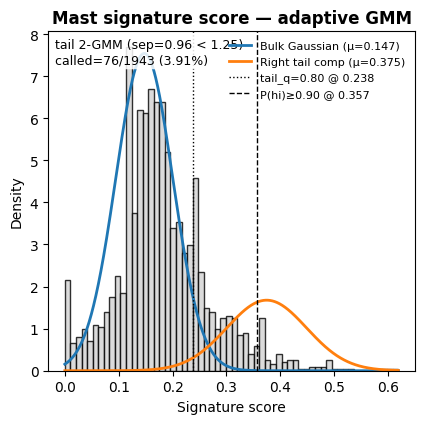

[Mast] max_rank=21 wrote score='Mast_signature_score' labels='Averaged.Detailed.Celltype.Final'
[Mast] {'status': 'ok', 'method': 'tail 2-GMM (sep=0.96 < 1.25)', 'sep': 0.9573704510571538, 'tail_q': 0.8, 'tail_cut': 0.238095223903656, 'means_tail': [0.2737817623484393, 0.3746151480475151], 'hi_tail_component': 1, 'posterior_threshold': 0.9, 'cut': 0.35674981655866994, 'n_called': 76, 'n_total_finite': 1943, 'n_tail': 424}


In [28]:
PBMC_HD01 = ep.add_mast_annotation(
    PBMC_HD01,
    layer="Normalized_reads",
    label_in='Averaged.Detailed.Celltype.Refined',
    label_out='Averaged.Detailed.Celltype.Final',
    plot_gmm=True,
    tail_q=0.80,
    plot_title="Mast signature score — adaptive GMM",
    verbose=True
)

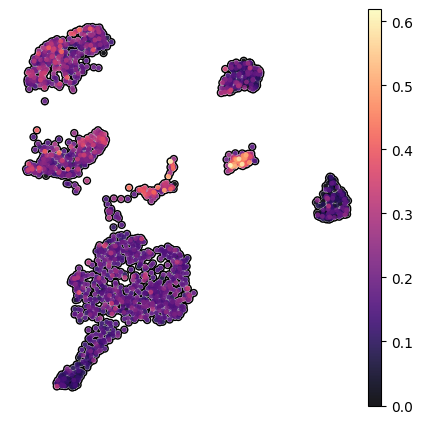

In [29]:
# -------- Build minimal AnnData --------
coords = np.asarray(PBMC_HD01.protein.row_attrs["umap"])
if coords.ndim != 2 or coords.shape[1] < 2:
    raise ValueError(f"row_attrs['umap'] must be (n_cells, >=2). Got {coords.shape}")
coords = coords[:, :2]

df_protein = PBMC_HD01.protein.get_attribute("Normalized_reads", constraint="row+col")

pbmc = AnnData(X=np.asarray(df_protein.values))
pbmc.obs_names = df_protein.index.astype(str)
pbmc.var_names = df_protein.columns.astype(str)
pbmc.obsm["X_umap"] = coords

# add score column
pbmc.obs["Mast_signature_score"] = np.asarray(PBMC_HD01.protein.row_attrs["Mast_signature_score"], dtype=float)

# -------- Plot (1x1) --------
with rc_context({"figure.figsize": (4.35, 4.35)}):
    fig, ax = plt.subplots(1, 1, figsize=(4.35, 4.35))

    sc.pl.umap(
        pbmc,
        color="Mast_signature_score",
        add_outline=True,
        cmap="magma",
        frameon=False,
        size=50,
        alpha=0.9,
        title="",
        ax=ax,
        show=False,
    )

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])

    fig.tight_layout()

    plt.show()
    plt.close(fig)

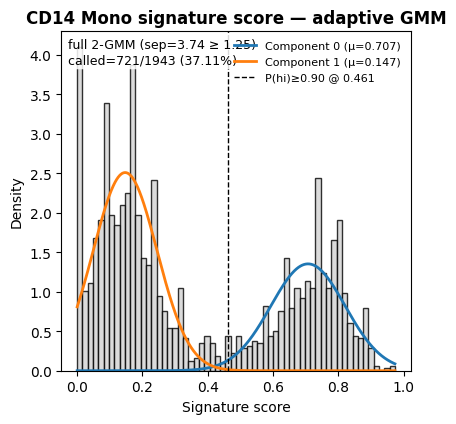

[CD14_Mono] max_rank=21 wrote score='CD14_Mono_signature_score' labels='Averaged.Detailed.Celltype.Final'
[CD14_Mono] {'status': 'ok', 'method': 'full 2-GMM (sep=3.74 ≥ 1.25)', 'sep': 3.736231391631521, 'means': [0.706839351284434, 0.14690068324858557], 'hi_component': 0, 'posterior_threshold': 0.9, 'cut': 0.46093317691894575, 'n_called': 721, 'n_total_finite': 1943}


In [30]:
PBMC_HD01 = ep.add_signature_annotation(
    PBMC_HD01,
    layer="Normalized_reads",
    label_in='Averaged.Detailed.Celltype.Final',
    label_out='Averaged.Detailed.Celltype.Final',
    positive_markers=["CD14", "CD33", "CD11b", "CD64"],
    negative_markers="",
    cell_type_label="CD14_Mono",
    verbose=True,
    plot_gmm=True,
    plot_title="CD14 Mono signature score — adaptive GMM",
    tail_q=0.80,
)

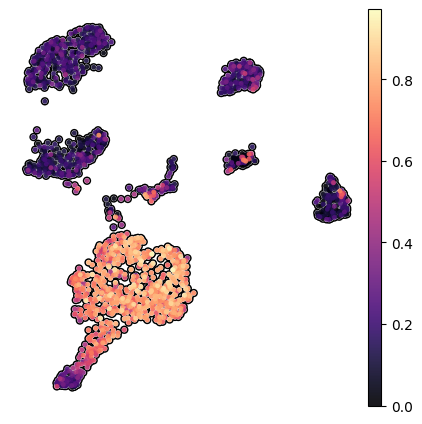

In [31]:
# -------- Build minimal AnnData --------
coords = np.asarray(PBMC_HD01.protein.row_attrs["umap"])
if coords.ndim != 2 or coords.shape[1] < 2:
    raise ValueError(f"row_attrs['umap'] must be (n_cells, >=2). Got {coords.shape}")
coords = coords[:, :2]

df_protein = PBMC_HD01.protein.get_attribute("Normalized_reads", constraint="row+col")

pbmc = AnnData(X=np.asarray(df_protein.values))
pbmc.obs_names = df_protein.index.astype(str)
pbmc.var_names = df_protein.columns.astype(str)
pbmc.obsm["X_umap"] = coords

# add score column
pbmc.obs["CD14_Mono_signature_score"] = np.asarray(PBMC_HD01.protein.row_attrs["CD14_Mono_signature_score"], dtype=float)

# -------- Plot (1x1) --------
with rc_context({"figure.figsize": (4.35, 4.35)}):
    fig, ax = plt.subplots(1, 1, figsize=(4.35, 4.35))

    sc.pl.umap(
        pbmc,
        color="CD14_Mono_signature_score",
        add_outline=True,
        cmap="magma",
        frameon=False,
        size=50,
        alpha=0.9,
        title="",
        ax=ax,
        show=False,
    )

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])

    fig.tight_layout()

    plt.show()
    plt.close(fig)

## Final visualization of refined cell type annotations

This UMAP plot displays the final refined cell type annotations after all processing steps including:
- Initial EspressoPro predictions
- Removal of small clusters (< 3 cells)
- Identification of mixed clusters
- Annotation refinement leveraging unsupervised clusters
- Addition of mast and custom cell type annotations

The `Averaged.Detailed.Celltype.Final` field represents the most accurate cell type assignments for each cell.

In [32]:
fig = PBMC_HD01.protein.scatterplot(attribute='umap',colorby='Averaged.Detailed.Celltype.Final')
go.Figure(fig)

In [33]:
PBMC_HD01.protein.signaturemap('Normalized_reads',
                           splitby='Averaged.Detailed.Celltype.Final')

In [34]:
PBMC_HD01 = ep.clear_annotation(PBMC_HD01)

In [35]:
PBMC_HD01.protein.row_attrs

{'barcode': array(['AACAACCTACAATCATAC', 'AACAACTGGTGATACCGT', 'AACAACTGGTGTCGTGAG',
        ..., 'TTGTCAACCGATGCTCCT', 'TTGTTAGAGTATACCACT',
        'TTGTTAGAGTTCGCATCC'], dtype=object),
 'label': array(['10', '41', '59', ..., '26', '6', '14'], dtype=object),
 'sample_name': array(['Sample 1', 'Sample 1', 'Sample 1', ..., 'Sample 1', 'Sample 1',
        'Sample 1'], dtype=object),
 'umap': array([[-1.8531094 , -5.202421  ],
        [ 6.764812  ,  5.726885  ],
        [ 1.8245363 ,  0.30699077],
        ...,
        [-4.29064   ,  6.840519  ],
        [ 6.4206023 ,  1.8086169 ],
        [-4.0272    ,  8.042387  ]], dtype=float32),
 'pca': array([[ 2.10821650e-02,  1.05522617e-03,  7.94752596e-03, ...,
          1.25842260e-02, -2.49469053e-02,  7.51712678e-03],
        [-2.00011460e-02,  1.18871596e-02, -5.41865570e-04, ...,
          1.65608537e-02, -2.05524563e-02, -3.86104037e-02],
        [ 1.18552927e-02,  1.73291668e-02,  6.52406893e-03, ...,
          2.09135165e-03, -6.75186738

# PBMC - HD02 Analysis

In [36]:
PBMC_HD02 = PBMC_samples.samples[1]

In [37]:
PBMC_HD02

## Normalisation

Performing two essential preprocessing steps:
1. **Normalization**: Corrects for technical variations and library size differences between cells using ADT CLR normalisation with Seurat flavour (akin to Muon ADT normalisation)
2. **Scaling**: Standardizes protein expression values to enable proper dimensionality reduction and downstream analysis

These steps ensure that subsequent dimensionality reduction and clustering are not biased by technical artifacts.

In [38]:
ep.Normalise_protein_data(PBMC_HD02, inplace=True, axis=1, flavor="seurat")
ep.Scale_protein_data(PBMC_HD02, inplace=True)

## Dimentionality reduction

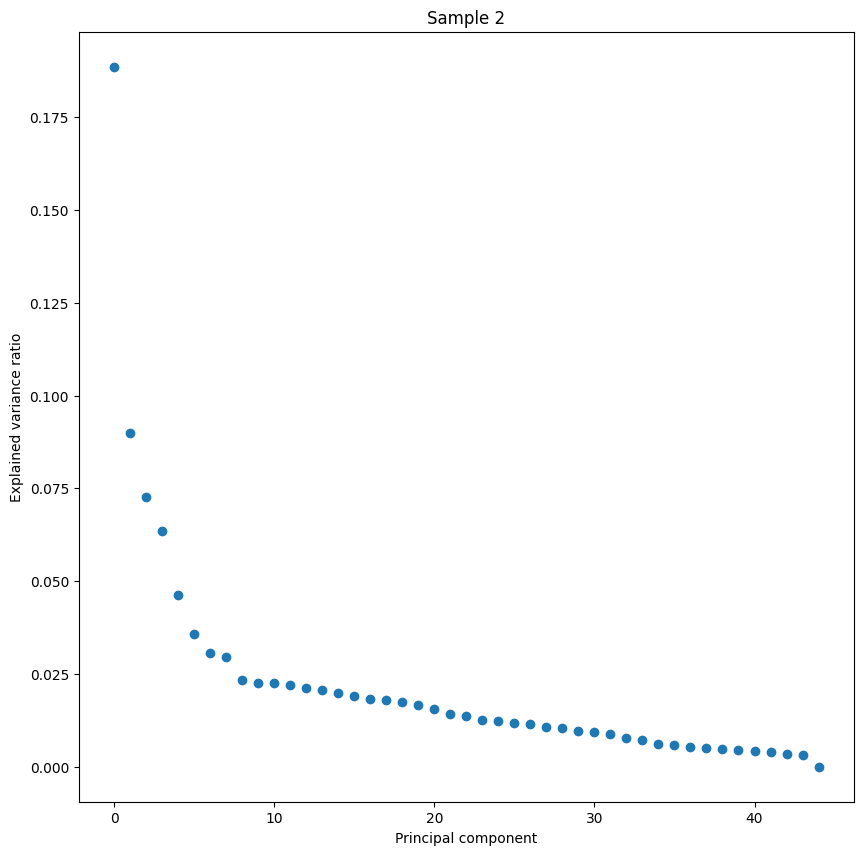

In [39]:
PBMC_HD02.protein.run_pca(attribute='Scaled_reads', components=45,show_plot=True, random_state=42, svd_solver='randomized')

We retain only those components that explain the majority of the variance, selecting the number of components at the point where additional components yield diminishing returns, as indicated by a plateau in variance explained.

In [40]:
PBMC_HD02.protein.run_pca(attribute='Scaled_reads', components=8, show_plot=False, random_state=42, svd_solver='randomized')

UMAP (Uniform Manifold Approximation and Projection) reduces the high-dimensional protein data to 2D for visualization while preserving local neighborhood structure. 

**Parameters used:**
- `n_neighbors=50`: Larger neighborhood for global structure preservation
- `min_dist=0.1`: Allows for tight clustering of similar cells  
- `spread=8`: Broader distribution of points in embedding space
- `random_state=42`: Ensures reproducible results

In [41]:
PBMC_HD02.protein.run_umap(attribute='pca', random_state=42, n_neighbors=50, min_dist=0.1, spread=8, n_components=2)

/Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/umap/umap_.py:1394: RuntimeWarning:

divide by zero encountered in power

/Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Unsupervised clustering

In [42]:
PBMC_HD02.protein.cluster(attribute='umap', method='graph-community', k=5, random_state=42) 

  0%|          | 0/9040 [00:00<?, ?it/s]

Number of clusters found: 72.
Modularity: 0.969


In [43]:
fig = PBMC_HD02.protein.scatterplot(attribute='umap',colorby='label')
go.Figure(fig)

In [44]:
PBMC_HD02.protein.row_attrs['Clusters'] = copy.copy(PBMC_HD02.protein.row_attrs['label'])

## EspressoPro predictions and annotation

EspressoPro uses machine learning models trained on extensive reference datasets to automatically predict cell types based on protein expression profiles. 

**Process:**
1. `generate_predictions()`: Creates probability scores for each potential cell type
2. `annotate_data()`: Assigns final cell type labels based on highest confidence predictions

**Output annotations:**
- `Simplified.Celltype`: Broad cell type categories (e.g., T cells, B cells, Monocytes)
- `Detailed.Celltype`: Specific cell subtypes (e.g., CD4+ T cells, CD8+ T cells, NK cells)

In [45]:
# Examples
PBMC_HD02 = ep.generate_predictions(obj=PBMC_HD02)
PBMC_HD02 = ep.annotate_data(obj=PBMC_HD02)

[generate_predictions] Using default models path: /Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/espressopro/data/Pre_trained_models/TotalSeqD_Heme_Oncology_CAT399906
[generate_predictions] Using default data path: /Users/kgurashi/anaconda3/envs/mosaic_2/lib/python3.10/site-packages/espressopro/data
[generate_predictions] Ensuring models are available...
[generate_predictions] Using all atlases: Hao, Triana, Zhang, Luecken
[generate_predictions] query_df shape: 1808 cells x 45 features
                        CD10     CD117     CD11b     CD11c     CD123      CD13     CD138      CD14     CD141      CD16     CD163      CD19
Normalized_reads                                                                                                                          
AACAACCTACATCTCACG  0.133586  0.000000  2.331154  0.133586  0.133586  0.000000  0.133586  3.202007  0.133586  0.133586  0.000000  0.133586
AACAACCTAGACGTCAAT  3.287248  0.032179  1.017367  0.093587  0.532445  

In [46]:
fig = PBMC_HD02.protein.scatterplot(attribute='umap',colorby='Averaged.Simplified.Celltype')
go.Figure(fig)

In [47]:
fig = PBMC_HD02.protein.scatterplot(attribute='umap',colorby='Averaged.Detailed.Celltype')
go.Figure(fig)

## Mark rare celltypes as "small"

Small-Cluster Flagging (Size-Based)

This step identifies **very small clusters** that are likely technical artifacts or rare, unreliable events and flags them as **Small**.

**Method:**
- For each cluster, count the number of cells
- If the cluster size is **below the minimum cell threshold** (e.g. < 3 cells),
  label **all cells in that cluster** as *Small*
- Otherwise, keep the original cell type labels
- Results are written to a new output column

**Why use this:**
- Reduces noise from spurious or low-support clusters  
- Prevents over-interpretation of rare events  
- Improves robustness and clarity of downstream analyses and visualizations  

In [48]:
PBMC_HD02 = ep.mark_small_clusters(
    PBMC_HD02,
    label_in="Averaged.Detailed.Celltype",
    label_out="Averaged.Detailed.Celltype.Small",
    cluster_col="Clusters",
    min_cells=3,
)

In [49]:
fig = PBMC_HD02.protein.scatterplot(attribute='umap',colorby='Averaged.Detailed.Celltype.Small')
go.Figure(fig)

In [50]:
PBMC_HD02.protein.signaturemap('Normalized_reads',
                           splitby='Averaged.Detailed.Celltype.Small')

## Mark clusters with mixed annotation as "mixed"

Cluster-Level Mixed-Label Detection (Frequency-Based)

This step identifies clusters that do **not** have a dominant cell type and flags them as **Mixed**.

**Method:**
- For each cluster, count cell type labels
- Compute the frequency of the most common label
- If this frequency is **below the threshold**, label **all cells in the cluster** as *Mixed*
- Otherwise, keep the original cell type labels
- Results are written to a new output column

**Why use this:**
- Explicitly flags heterogeneous clusters  
- Prevents over-interpreting mixed populations  
- Provides a clean checkpoint before downstream refinement or consensus steps

In [51]:
PBMC_HD02 = ep.mark_mixed_clusters(
    PBMC_HD02,
    label_in="Averaged.Detailed.Celltype.Small",
    label_out="Averaged.Detailed.Celltype.Mixed",
    cluster_col="Clusters",
    min_frequency_threshold=0.35,
)


In [52]:
fig = PBMC_HD02.protein.scatterplot(attribute='umap',colorby='Averaged.Detailed.Celltype.Mixed')
go.Figure(fig)

In [53]:
PBMC_HD02.protein.signaturemap('Normalized_reads',
                           splitby='Averaged.Detailed.Celltype.Mixed')

## Refine and expand annotation using unsupervised data

Cluster-Level Cell Type Assignment (Frequency-Based)

This step assigns a **single cell type per cluster** based on label frequency.

**Method:**
- For each cluster, count cell type labels
- If the most frequent label exceeds the dominance threshold, assign it to all cells
- Otherwise, label the entire cluster as **Mixed** (same as *mark_mixed_clusters*)
- Results are written to the output label column

**Why use this:**
- Enforces cluster consistency  
- Flags heterogeneous clusters clearly

In [54]:
PBMC_HD02, summary, pivot = ep.suggest_cluster_celltype_identity(
    sample=PBMC_HD02,
    dominance_threshold=0.35,
    label_in="Averaged.Detailed.Celltype.Mixed",
    cluster_col="Clusters",
    label_out="Averaged.Detailed.Celltype.Refined",
    rewrite=True,
    verbose=True
)

cluster=40 n=24 top=CD14_Mono (91.67%) -> CD14_Mono
cluster=62 n=11 top=B_Memory (45.45%) -> B_Memory
cluster=11 n=39 top=CD14_Mono (97.44%) -> CD14_Mono
cluster=30 n=28 top=CD4_T_Memory (100.00%) -> CD4_T_Memory
cluster=29 n=28 top=CD14_Mono (96.43%) -> CD14_Mono
cluster=37 n=25 top=pDC (80.00%) -> pDC
cluster=10 n=39 top=Mixed (100.00%) -> Mixed
cluster=20 n=33 top=CD4_T_Memory (90.91%) -> CD4_T_Memory
cluster=13 n=36 top=CD8_T_Memory (80.56%) -> CD8_T_Memory
cluster=45 n=21 top=CD14_Mono (61.90%) -> CD14_Mono
cluster=7 n=42 top=CD16_Mono (95.24%) -> CD16_Mono
cluster=46 n=21 top=CD14_Mono (85.71%) -> CD14_Mono
cluster=1 n=48 top=CD4_T_Memory (85.42%) -> CD4_T_Memory
cluster=21 n=33 top=CD8_T_Memory (39.39%) -> CD8_T_Memory
cluster=55 n=16 top=B_Memory (68.75%) -> B_Memory
cluster=39 n=24 top=NK_CD56_dim (95.83%) -> NK_CD56_dim
cluster=9 n=41 top=CD14_Mono (95.12%) -> CD14_Mono
cluster=26 n=29 top=CD4_T_Memory (82.76%) -> CD4_T_Memory
cluster=61 n=11 top=B_Memory (81.82%) -> B_Memory

In [55]:
PBMC_HD02.protein.signaturemap('Normalized_reads',
                           splitby='Averaged.Detailed.Celltype.Refined')

## Annotate custom celltypes using known signatures

Signature-Based Cell Type Annotation (Mast / Custom)

This step identifies cells expressing a **specific protein marker signature** using pyUCell scores and probabilistic modeling.

**Method:**

* Compute a pyUCell signature score from positive (and optional negative) markers
* Model the score distribution with an **adaptive GMM**
* Select cells from the **right-hand (high-score) component** with high posterior probability
* Relabel only those cells as the target cell type
* Optionally plot the GMM fit for QC

**Why use this:**

* Reliably detects rare or subtle populations
* Avoids hard score thresholds
* Adapts to both bimodal and skewed (tail-heavy) distributions
* Provides interpretable QC plots


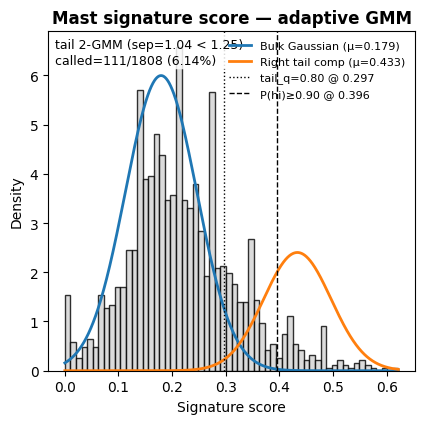

[Mast] max_rank=22 wrote score='Mast_signature_score' labels='Averaged.Detailed.Celltype.Final'
[Mast] {'status': 'ok', 'method': 'tail 2-GMM (sep=1.04 < 1.25)', 'sep': 1.0365661979299214, 'tail_q': 0.8, 'tail_cut': 0.29729729890823364, 'means_tail': [0.32852167769909935, 0.4334402231783074], 'hi_tail_component': 1, 'posterior_threshold': 0.9, 'cut': 0.39617105028878574, 'n_called': 111, 'n_total_finite': 1808, 'n_tail': 386}


In [56]:
PBMC_HD02 = ep.add_mast_annotation(
    PBMC_HD02,
    layer="Normalized_reads",
    label_in='Averaged.Detailed.Celltype.Refined',
    label_out='Averaged.Detailed.Celltype.Final',
    plot_gmm=True,
    tail_q=0.80,
    plot_title="Mast signature score — adaptive GMM",
    verbose=True
)

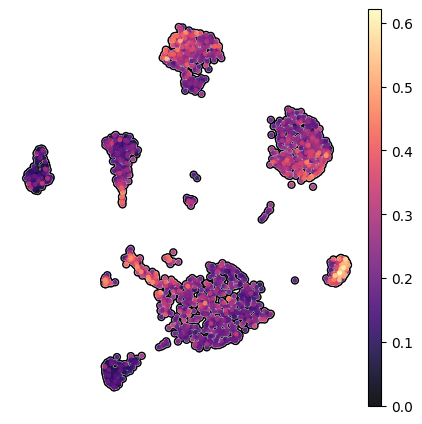

In [57]:
# -------- Build minimal AnnData --------
coords = np.asarray(PBMC_HD02.protein.row_attrs["umap"])
if coords.ndim != 2 or coords.shape[1] < 2:
    raise ValueError(f"row_attrs['umap'] must be (n_cells, >=2). Got {coords.shape}")
coords = coords[:, :2]

df_protein = PBMC_HD02.protein.get_attribute("Normalized_reads", constraint="row+col")

pbmc = AnnData(X=np.asarray(df_protein.values))
pbmc.obs_names = df_protein.index.astype(str)
pbmc.var_names = df_protein.columns.astype(str)
pbmc.obsm["X_umap"] = coords

# add score column
pbmc.obs["Mast_signature_score"] = np.asarray(PBMC_HD02.protein.row_attrs["Mast_signature_score"], dtype=float)

# -------- Plot (1x1) --------
with rc_context({"figure.figsize": (4.35, 4.35)}):
    fig, ax = plt.subplots(1, 1, figsize=(4.35, 4.35))

    sc.pl.umap(
        pbmc,
        color="Mast_signature_score",
        add_outline=True,
        cmap="magma",
        frameon=False,
        size=50,
        alpha=0.9,
        title="",
        ax=ax,
        show=False,
    )

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])

    fig.tight_layout()

    plt.show()
    plt.close(fig)

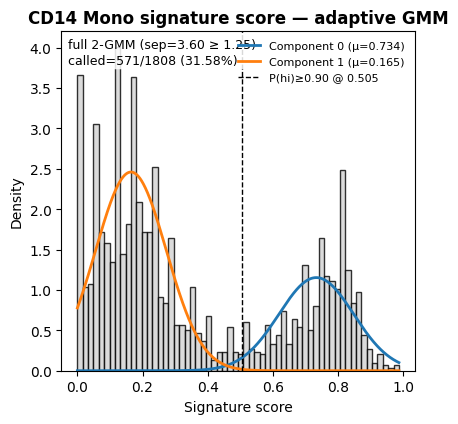

[CD14_Mono] max_rank=22 wrote score='CD14_Mono_signature_score' labels='Averaged.Detailed.Celltype.Final'
[CD14_Mono] {'status': 'ok', 'method': 'full 2-GMM (sep=3.60 ≥ 1.25)', 'sep': 3.602366646141438, 'means': [0.7335128135451955, 0.16451846617682936], 'hi_component': 0, 'posterior_threshold': 0.9, 'cut': 0.505194890284431, 'n_called': 571, 'n_total_finite': 1808}


In [58]:
PBMC_HD02 = ep.add_signature_annotation(
    PBMC_HD02,
    layer="Normalized_reads",
    label_in='Averaged.Detailed.Celltype.Final',
    label_out='Averaged.Detailed.Celltype.Final',
    positive_markers=["CD14", "CD33", "CD11b", "CD64"],
    negative_markers="",
    cell_type_label="CD14_Mono",
    verbose=True,
    plot_gmm=True,
    plot_title="CD14 Mono signature score — adaptive GMM",
    tail_q=0.80,
)

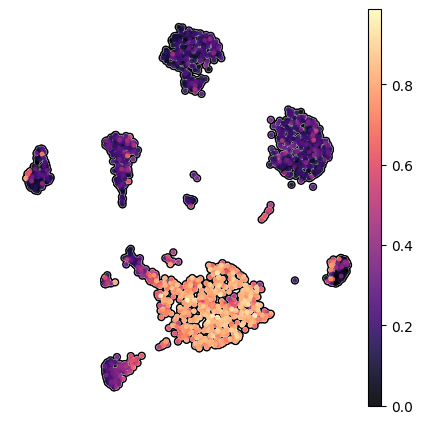

In [59]:
# -------- Build minimal AnnData --------
coords = np.asarray(PBMC_HD02.protein.row_attrs["umap"])
if coords.ndim != 2 or coords.shape[1] < 2:
    raise ValueError(f"row_attrs['umap'] must be (n_cells, >=2). Got {coords.shape}")
coords = coords[:, :2]

df_protein = PBMC_HD02.protein.get_attribute("Normalized_reads", constraint="row+col")

pbmc = AnnData(X=np.asarray(df_protein.values))
pbmc.obs_names = df_protein.index.astype(str)
pbmc.var_names = df_protein.columns.astype(str)
pbmc.obsm["X_umap"] = coords

# add score column
pbmc.obs["CD14_Mono_signature_score"] = np.asarray(PBMC_HD02.protein.row_attrs["CD14_Mono_signature_score"], dtype=float)

# -------- Plot (1x1) --------
with rc_context({"figure.figsize": (4.35, 4.35)}):
    fig, ax = plt.subplots(1, 1, figsize=(4.35, 4.35))

    sc.pl.umap(
        pbmc,
        color="CD14_Mono_signature_score",
        add_outline=True,
        cmap="magma",
        frameon=False,
        size=50,
        alpha=0.9,
        title="",
        ax=ax,
        show=False,
    )

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])

    fig.tight_layout()

    plt.show()
    plt.close(fig)

## Final visualization of refined cell type annotations

This UMAP plot displays the final refined cell type annotations after all processing steps including:
- Initial EspressoPro predictions
- Removal of small clusters (< 3 cells)
- Identification of mixed clusters
- Annotation refinement leveraging unsupervised clusters
- Addition of mast and custom cell type annotations

The `Averaged.Detailed.Celltype.Final` field represents the most accurate cell type assignments for each cell.

In [60]:
fig = PBMC_HD02.protein.scatterplot(attribute='umap',colorby='Averaged.Detailed.Celltype.Final')
go.Figure(fig)

In [61]:
PBMC_HD02.protein.signaturemap('Normalized_reads',
                           splitby='Averaged.Detailed.Celltype.Final')

In [62]:
PBMC_HD02 = ep.clear_annotation(PBMC_HD02)

In [63]:
PBMC_HD02.protein.row_attrs

{'barcode': array(['AACAACCTACATCTCACG', 'AACAACCTAGACGTCAAT', 'AACAACCTAGCCTTATCT',
        ..., 'TTGTAATGCGGTTACGCA', 'TTGTATCACCATGCCAGT',
        'TTGTATCACGAGGTGAGC'], dtype=object),
 'label': array(['40', '62', '11', ..., '35', '7', '24'], dtype=object),
 'sample_name': array(['Sample 2', 'Sample 2', 'Sample 2', ..., 'Sample 2', 'Sample 2',
        'Sample 2'], dtype=object),
 'umap': array([[ 1.7908065, -4.373233 ],
        [-9.856196 ,  3.084514 ],
        [-1.4847405, -5.370721 ],
        ...,
        [ 5.2660065,  2.5252156],
        [-5.3727574, -8.190922 ],
        [ 1.2985611, -5.445605 ]], dtype=float32),
 'pca': array([[-0.00102705, -0.03095158,  0.00200638, ...,  0.01753008,
         -0.00050096,  0.02050159],
        [-0.01869466,  0.03691829, -0.0352976 , ...,  0.04134602,
          0.00871788,  0.06491078],
        [ 0.02779635, -0.00206289,  0.01278974, ..., -0.00967898,
          0.00577518, -0.01515647],
        ...,
        [-0.02049737, -0.03123458, -0.01413645,

# Analysis Summary

## Completed Analysis Pipeline

This notebook successfully demonstrates a comprehensive single-cell protein analysis workflow using two PBMC samples (HD01 and HD02). Each sample underwent identical processing steps:

### Key Analysis Steps:
1. **Data preprocessing** - Normalization and scaling of protein expression
2. **Dimensionality reduction** - PCA followed by UMAP for visualization  
3. **Unsupervised clustering** - Graph-community detection for initial cell grouping
4. **Automated annotation** - EspressoPro machine learning predictions
5. **Quality control** - Detection of small clusters and mixed populations
6. **Refinement** -  Cluster-based improvements
7. **Specialized detection** - Mast or custom cell types identification
8. **Validation** - Multiple visualization methods (UMAP, heatmaps, signature maps)

### Final Results:
- **High-quality cell type annotations** with multiple levels of detail
- **Robust cell populations** validated through multiple approaches
- **Comprehensive visualization** enabling biological interpretation
- **Reproducible workflow** suitable for similar datasets

### Applications:
This analysis framework can be applied to:
- Clinical sample characterization
- Treatment response studies  
- Cell atlas construction
- Biomarker discovery
- Quality control for single-cell experiments